## Hybrid coding scheme for diagonal Gaussians

```
Copyright 2022 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
```

In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Below are basic implementations of two general reverse channel coding schemes based on the Poisson functional representation (Li & El Gamal, 2018) and the hybrid coding scheme (Theis & Yosri, 2022). These implementations are meant for educational purposes and were not designed for production use.

Using these functions, a sample from a continuous target distribution $q$ can be encoded into a low-entropy integer code. It is assumed that the encoder and decoder have shared knowledge of a proposal distribution $p$ and a random seed (given in the form of `rs` below).

In [3]:
def sample_pfr(q, p, w_min, rs=np.random.RandomState(0)):
  """
  Reverse channel coding scheme based on the Poisson functional representation
  (Li & El Gamal, 2018).

  Parameters
  ----------
  q: sp.stats.rv_continuous
    Target distribution

  p: sp.stats.rv_continuous
    Prior distribution known to decoder

  w_min: float
    Lower bound on the density ratio, ideally inf_z p(z) / q(z)

  Returns
  -------
  tuple
    Returns a sample, its code, and the number of iterations that were needed
    to identify the code.
  """

  if w_min > 1.0 or w_min < 0.0 or np.isnan(w_min):
    raise ValueError('`w_min` should not be outside the range [0, 1]')

  t = 0  # Poisson process
  s = np.inf  # score of current best candidate
  n = 0  # index of last accepted proposal
  i = 0  # index of current proposal considered
  z = None  # value of last accepted sample

  while s > t * w_min:
    # draw candidate from proposal distribution
    z_ = p.rvs(random_state=rs)

    # advance Poisson process
    t += rs.exponential()

    # evaluate candidate
    s_ = t * np.prod(p.pdf(z_) / q.pdf(z_))

    # accept/reject candidate
    if s_ < s:
      n = i
      s = s_
      z = z_

    i += 1

  return {'sample': z, 'code': n, 'iterations': i}

def sample_hybrid(q, p, w_min, M, rs=np.random.RandomState(0)):
  """
  Hybrid reverse channel coding scheme based on universal quantization
  and the Poisson functional representation (Theis & Yosri, 2022).

  This implementation assumes that q.a and q.b indicate the support of the
  distribution. Note that Scipy's truncated distributions implement q.a and
  q.b but these do *not* directly correspond to the distributions' support.

  Parameters
  ----------
  q: sp.stats.rv_continuous
    Target distribution with finite support indicated by q.a and q.b

  p: sp.stats.rv_continuous
    Prior distribution known to decoder

  w_min: float
    Lower bound on the density ratio, ideally inf_z p(z) / q(z)

  M: np.ndarray
    After transformation, the support of p is at least M times the support of q

  Returns
  -------
  tuple
    Returns (z, n, k, i), where (n, k) is a code for the sample z and
    i is the number of iterations that were needed to find the code.
  """

  if w_min > 1.0 or w_min < 0.0 or np.isnan(w_min):
    raise ValueError('`w_min` should not be outside the range [0, 1]')

  dim = p.mean().size

  # transformation, its inverse, and its log-derivative
  phi = lambda u: p.ppf(u / M)
  phi_inv = lambda z: p.cdf(z) * M
  log_phi_prime = lambda u: -p.logpdf(phi(u)) - np.log(M)

  # transform target distribution
  q_phi_logpdf = lambda u: q.logpdf(phi(u)) + log_phi_prime(u)

  # transform support of target distribution
  q_phi_support = phi_inv(np.asarray([q.a, q.b]))

  if np.any(np.abs(np.diff(q_phi_support, axis=0)) > 1):
    raise ValueError('The support of the target distribution is too large')

  # center of bridge proposal distribution
  c = np.mean(q_phi_support, axis=0)

  # don't generate proposals outside support of p
  c = np.clip(c, 0.5, M - 0.5)
  
  # apply reverse channel coding
  t = 0  # Poisson process
  s = np.inf  # score of last accepted proposal
  n = 0  # index of last accepted proposal
  i = 0  # index of current proposal

  while np.exp(s) > t * w_min * np.prod(M):
    # generate candidate using universal quantization
    u = rs.rand(dim)
    k_ = np.array(c - u + 0.5, dtype=int)  # equals round(c - u) since c - u + 0.5 >= 0
    y_ = k_ + u

    # evaluate candidate
    t += rs.exponential()
    s_ = np.log(t) - np.sum(q_phi_logpdf(y_))

    # accept/reject candidate
    if s_ < s:
      n = i
      s = s_
      k = k_
      y = y_

    i += 1

  # transform sample back
  z = phi(y)

  # n and k contain all the information needed to produce z
  return {
    'sample': z,
    'code': (n, np.asarray(k, dtype=int)),
    'iterations': i}

In [4]:
def decode_hybrid(n, k, p, M, rs=np.random.RandomState(0)):
  """
  Accepts a code representing a sample and decodes it.

  Parameters
  ----------
  n: int
    The index of the candidate

  k: int
    Additional information required to generate the candidate

  p: sp.stats.rv_continuous
    Assumed marginal distribution of the samples

  M: np.ndarray
    See Theis & Yosri (2022) for an explanation of this parameter

  Returns
  -------
  numpy.ndarray
    A decoded sample
  """

  dim = p.mean().size

  # transformation, its inverse, and its log-derivative
  phi = lambda u: p.ppf(u / M)

  # advance random seed
  for _ in range(n + 1):
    u = rs.rand(dim)
    rs.exponential()

  return phi(k + u)

The code below deals with the special case of diagonal Gaussian target and proposal distributions.

In [5]:
def minimum_weight(q, p):
  """
  Returns min_z p(z) / q(z) for normal distributions q and p.
  """
  assert np.all(p.var() >= q.var())

  with np.errstate(invalid='ignore'):
    x_min = (p.var() * q.mean() - q.var() * p.mean()) / (p.var() - q.var())
    w_min = p.logpdf(x_min) - q.logpdf(x_min)

  return np.where(np.isnan(w_min), 1.0, np.exp(w_min))

def sample_gaussian(q, p, D=1e-4, rs=np.random.RandomState(0)):
  """
  Encodes diagonal Gaussian using hybrid coding scheme.

  Parameters
  ----------
  q: sp.stats.rv_continuous
    Target normal distribution

  p: sp.stats.rv_continuous
    Marginal normal distribution

  D: float
   Controls fraction of mass of q truncated
 
  rs: numpy.random.RandomState
    Source of randomness shared between encoder and decoder

  Returns
  -------
  dict
    A dictionary containing the a sample, its code and additional information
  """

  dim = q.mean().size

  # adjust for dimensionality
  D = 1.0 - np.power(1.0 - D, 1.0 / dim)

  # support of standard truncated normal
  a = sp.stats.norm().ppf(D / 2.0)
  b = sp.stats.norm().ppf(1.0 - D / 2.0)

  # approximate normal with truncated normal
  q_tr = sp.stats.truncnorm(a=a, b=b, loc=q.mean(), scale=q.std())

  # fix broken support indicators
  q_tr.a = q_tr.a * q.std() + q.mean()
  q_tr.b = q_tr.b * q.std() + q.mean()

  # determine support of widest q (after transformation with p.cdf)
  c = p.cdf(p.mean() - q_tr.mean() + q_tr.a)
  d = p.cdf(p.mean() - q_tr.mean() + q_tr.b)
  M = np.asarray(np.floor(1 / (d - c)), dtype=int)

  # lower bound on w_min = min_z p(z) / q_tr(z)
  w_min = np.prod(minimum_weight(q, p) * (1 - D)) 
  results = sample_hybrid(q_tr, p, w_min, M, rs)
  results['factor'] = M
  return results

The following cell encodes Gaussian samples.

In [6]:
mean_scale = np.asarray([40.0, 20.0])
target_scale = np.asarray([1.0, 1.0])

# proposal distribution
p = sp.stats.norm(
    loc=[0, 0],
    scale=np.sqrt(target_scale ** 2 + mean_scale ** 2))

# target distributions
targets = []
for _ in range(2000):
  target_mean = np.random.randn(2) * mean_scale
  targets.append(sp.stats.norm(loc=target_mean, scale=target_scale))

# encode samples
samples = [
  sample_gaussian(q, p, D=1e-4, rs=np.random.RandomState(i))
  for i, q in enumerate(targets)]

The following cell decodes the Gaussian samples. While it is not obvious from the implementation of `sample_gaussian`, the factor `M` is independent of the mean of `q`. This allows us to use it in the decoding step below.

In [7]:
# decode samples
z = [
  decode_hybrid(
      n=s['code'][0],
      k=s['code'][1],
      p=p,
      M=s['factor'],
      rs=np.random.RandomState(i))
  for i, s in enumerate(samples)]
z = np.asarray(z)

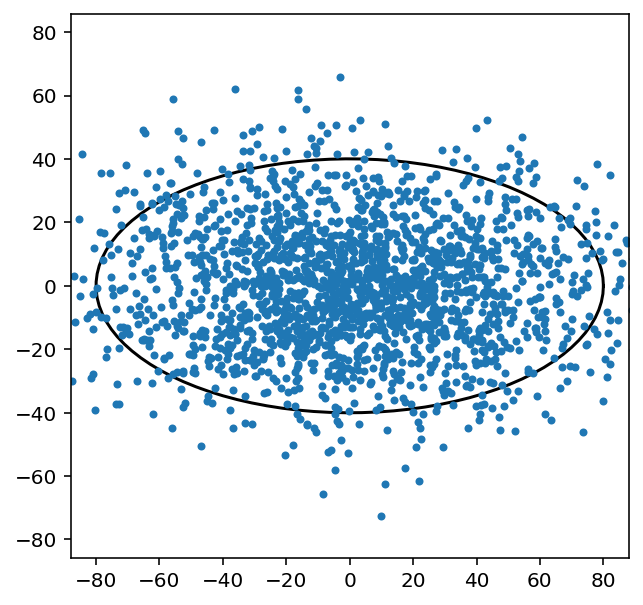

In [8]:
t = np.linspace(0, 2 * np.pi, 100)
x = np.cos(t) * p.std()[0] * 2
y = np.sin(t) * p.std()[1] * 2

# visualize prior distribution and samples
plt.figure(figsize=(5, 5))
plt.plot(x, y, 'k')
xl, yl = plt.xlim(), plt.ylim()
plt.plot(z[:, 0], z[:, 1], '.')
plt.axis('equal')
plt.xlim(*xl)
plt.ylim(*yl);

Below we estimate the cost of encoding the samples, and check that the cost agrees with the theoretical bound on the coding cost.

In [9]:
def coding_cost_hybrid(q, p, sample):
  """
  Estimate the coding cost (assuming a Zipf distribution)
  as well as theoretical upper and lower bounds.

  The target and marginal distribution are used to compute the bounds
  and the parameter of the Zipf distribution used to encode the sample.
  It is assumed that the entropy of `q` is the same across
  target distributions and that `p` is the marginal distribution, i.e.,
  E[q_X(z)] = p(z).

  Parameters
  ----------
  q: sp.stats.rv_continuous
    Target distribution

  p: sp.stats.rv_continuous
    Marginal distribution

  sample: dict
    A single sample as produced by `sample_hybrid`

  Returns
  -------
  dict
    Coding cost and bounds
  """

  # mutual information between source and communicated sample
  marg_diff_entropy = p.entropy().sum() / np.log(2)
  cond_diff_entropy = q.entropy().sum() / np.log(2)
  mi = marg_diff_entropy - cond_diff_entropy

  # upper bound on entropy
  log2M = np.log2(sample['factor']).sum()
  coding_cost_bound = mi + np.log2(mi - log2M + 1) + 4

  # coding cost of N under Zipf distribution
  exponent = 1.0 + 1.0 / (1.0 + np.log2(np.e) / np.e + mi - log2M)
  log2Pn = -exponent * np.log2(sample['code'][0] + 1)
  log2Pn = log2Pn - np.log2(sp.special.zeta(exponent))

  # coding cost of N and K (log2M is the cost of encoding K)
  coding_cost_zipf = -log2Pn + log2M

  return {
      'zipf': coding_cost_zipf,
      'lower_bound': mi,
      'upper_bound': coding_cost_bound,
  }

In [10]:
coding_costs = [coding_cost_hybrid(q, p, s) for q, s in zip(targets, samples)]
print('{:.4f} <= {:.4f} <= {:.4f}'.format(
    coding_costs[0]['lower_bound'],
    np.mean([c['zipf'] for c in coding_costs]),
    coding_costs[0]['upper_bound']))

9.6461 <= 12.2743 <= 15.8084


Below we measure the computational efficiency of the hybrid coding scheme.

In [11]:
np.random.seed(1)

dim = 2
mean_scales = np.linspace(0, 50, 8)
num_samples = 200
coding_costs = []

samples = []
targets = []

for sigma in tqdm(mean_scales):
  mean_scale = np.ones(dim) * sigma
  target_scale = np.ones(dim)

  # prior/marginal distribution of communicated sample
  p = sp.stats.norm(
    loc=np.zeros(dim),
    scale=np.sqrt(target_scale ** 2 + mean_scale ** 2))

  # draw random target distributions
  targets.append([])
  for _ in range(num_samples):
    target_mean = np.random.randn(dim) * mean_scale
    targets[-1].append(sp.stats.norm(loc=target_mean, scale=target_scale))

  # encode samples
  samples.append([
      sample_gaussian(
          q,
          p,
          D=1e-4,
          rs=np.random.RandomState(i))
      for i, q in enumerate(targets[-1])])
  coding_costs.append([
      coding_cost_hybrid(q, p, s)
      for q, s in zip(targets[-1], samples[-1])])

100%|██████████| 8/8 [01:33<00:00, 11.72s/it]


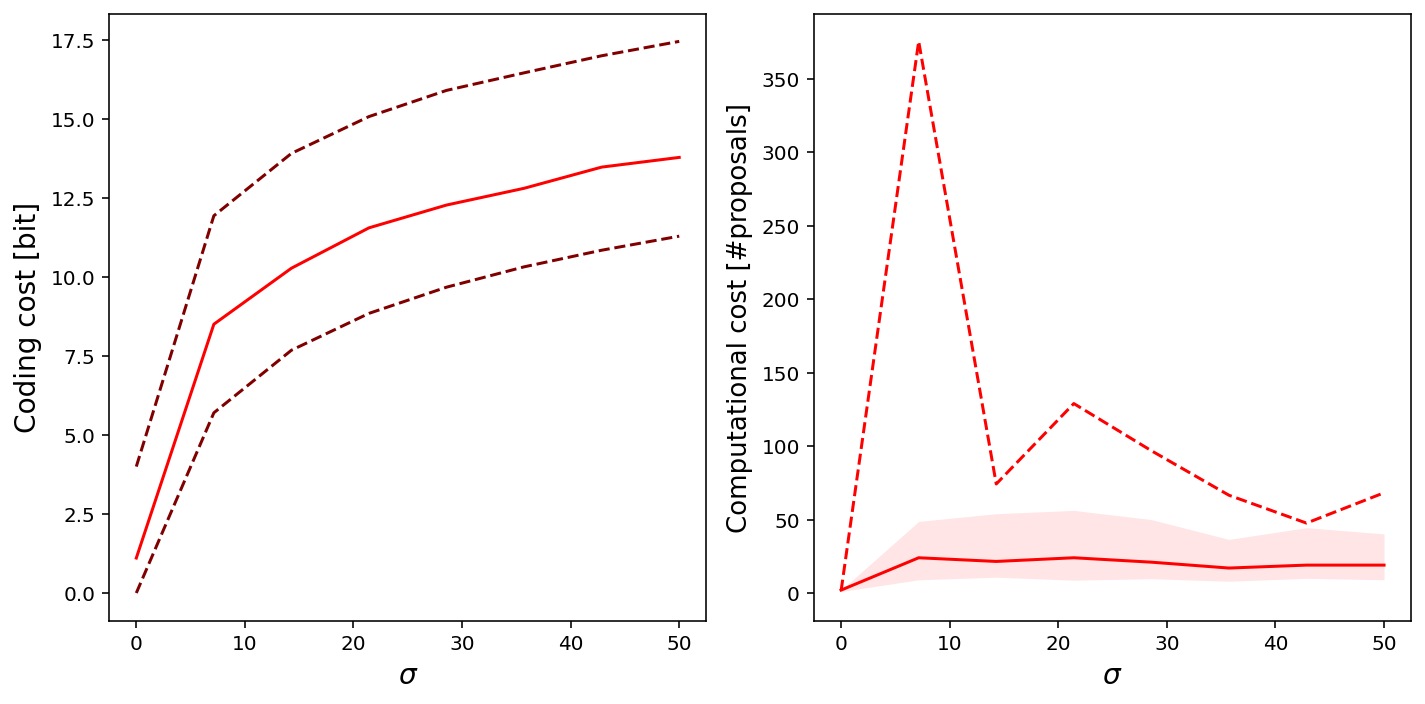

In [12]:
plt.figure(figsize=(10, 5))

# plot coding costs
plt.subplot(1, 2, 1)

coding_cost_lower = [cc[0]['lower_bound'] for cc in coding_costs]  # mutual information
coding_cost_upper = [cc[0]['upper_bound'] for cc in coding_costs]
coding_cost_zipf = [np.mean([c['zipf'] for c in cc]) for cc in coding_costs]

plt.plot(mean_scales, coding_cost_zipf, 'r')
plt.plot(mean_scales, coding_cost_lower, color=(0.5, 0, 0), ls='--')
plt.plot(mean_scales, coding_cost_upper, color=(0.5, 0, 0), ls='--')
plt.xlabel(r'$\sigma$', fontsize=14)
plt.ylabel('Coding cost [bit]', fontsize=14)

# plot computational cost
plt.subplot(1, 2, 2)

num_iter_hybrid_10 = [np.percentile([s['iterations'] for s in ss], 10) for ss in samples]
num_iter_hybrid_25 = [np.percentile([s['iterations'] for s in ss], 25) for ss in samples]
num_iter_hybrid_50 = [np.median([s['iterations'] for s in ss]) for ss in samples]
num_iter_hybrid_75 = [np.percentile([s['iterations'] for s in ss], 75) for ss in samples]
num_iter_hybrid_90 = [np.percentile([s['iterations'] for s in ss], 90) for ss in samples]
num_iter_mean = [np.mean([s['iterations'] for s in ss]) for ss in samples]

plt.plot(mean_scales, num_iter_hybrid_50, 'r')
plt.plot(mean_scales, num_iter_mean, 'r--')
plt.fill_between(
    np.hstack([mean_scales, mean_scales[::-1]]),
    np.hstack([num_iter_hybrid_25, num_iter_hybrid_75[::-1]]),
    color='r',
    alpha=0.1,
    lw=0)
plt.xlabel(r'$\sigma$', fontsize=14)
plt.ylabel('Computational cost [#proposals]', fontsize=13)
plt.tight_layout();